In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from openpyxl.styles.alignment import Alignment

In [2]:
base_folder = '/Users/daniele/Postdoc/Research/CA3/OPTIMIZATIONS/'
cell_type = 'a-thorny'
if cell_type == 'thorny':
    cell_id = 'DH070813'
    optimization_run = '20191208071008'
    good_individuals = [0, 2, 8]
    vmax = 1
else:
    cell_id = 'DH070213C3'
    optimization_run = '20191206232623'
    good_individuals = [0, 2, 4, 5, 8, 59]
    vmax = 4
expt_folder = base_folder + cell_type.capitalize() + '/' + cell_id + '/' + \
    optimization_run + '_' + cell_id + '_/synaptic_cooperativity_num_spikes_experiment'
data_folders = glob.glob(expt_folder + '/individual_*')
individuals = list(map(int, [folder.split('_')[-1] for folder in data_folders]))
individuals.sort()
window = 500
n_spikes = {}
data = {}
for individual in individuals:
    data_folder = f'{expt_folder}/individual_{individual}'
    print(f'Analysing data in {data_folder} ...')
    data_files = glob.glob(data_folder + '/*.npz')
    data_files.sort(key=os.path.getmtime)
    data[individual] = [np.load(f, allow_pickle=True) for f in data_files]
    spike_dt = np.array([d['config'][()]['spike_dt'] for d in data[individual]])
    spine_distance = np.array([d['config'][()]['spine_distance'] for d in data[individual]])
    if spine_distance[0] == spine_distance[1]:
        x = spine_distance
        y = spike_dt
    else:
        x = spike_dt
        y = spine_distance
    N = np.where(np.diff(x) > 0)[0][0] + 1
    M = x.size // N
    shape = M,N
    spine_distance = np.reshape(spine_distance, shape)
    spike_dt = np.reshape(spike_dt, shape)
    
    presyn_burst_times = data[individual][0]['presyn_burst_times']
    n_spikes[individual] = {}
    for i,burst_time in enumerate(presyn_burst_times):
        n_spikes[individual][i+1] = []
        for d in data[individual]:
            idx, = np.where((d['spike_times'] > burst_time) & (d['spike_times'] < burst_time + window))
            n_spikes[individual][i+1].append(len(idx))
        n_spikes[individual][i+1] = np.reshape(n_spikes[individual][i+1], shape)

Analysing data in /Users/daniele/Postdoc/Research/CA3/OPTIMIZATIONS/A-thorny/DH070213C3/20191206232623_DH070213C3_/synaptic_cooperativity_num_spikes_experiment/individual_0 ...
Analysing data in /Users/daniele/Postdoc/Research/CA3/OPTIMIZATIONS/A-thorny/DH070213C3/20191206232623_DH070213C3_/synaptic_cooperativity_num_spikes_experiment/individual_2 ...
Analysing data in /Users/daniele/Postdoc/Research/CA3/OPTIMIZATIONS/A-thorny/DH070213C3/20191206232623_DH070213C3_/synaptic_cooperativity_num_spikes_experiment/individual_3 ...
Analysing data in /Users/daniele/Postdoc/Research/CA3/OPTIMIZATIONS/A-thorny/DH070213C3/20191206232623_DH070213C3_/synaptic_cooperativity_num_spikes_experiment/individual_4 ...
Analysing data in /Users/daniele/Postdoc/Research/CA3/OPTIMIZATIONS/A-thorny/DH070213C3/20191206232623_DH070213C3_/synaptic_cooperativity_num_spikes_experiment/individual_5 ...
Analysing data in /Users/daniele/Postdoc/Research/CA3/OPTIMIZATIONS/A-thorny/DH070213C3/20191206232623_DH070213C3_/

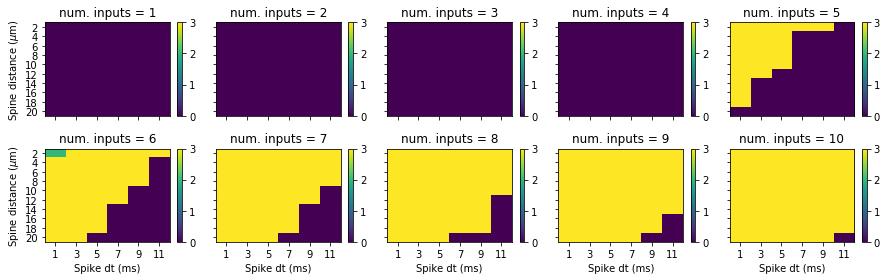

In [3]:
colormap = 'viridis'
rows = 2
cols = 5
fig,ax = plt.subplots(rows, cols, figsize=(cols*2.5, rows*2), sharex=True, sharey=True)
individual = 0
N_max = np.max([N.max() for N in n_spikes[individual].values()])
for i in range(rows):
    for j in range(cols):
        n_inputs = i*cols + j + 1
        im = ax[i,j].imshow(n_spikes[individual][n_inputs], aspect='auto', cmap=colormap, vmin=0, vmax=N_max)
        plt.colorbar(im, ax=ax[i,j])
        ax[i,j].set_title(f'num. inputs = {n_inputs}')
        ax[i,j].set_xticks(np.arange(shape[1]))
        ax[i,j].set_xticklabels(np.unique(spike_dt))
        ax[i,j].set_yticks(np.arange(shape[0]))
        ax[i,j].set_yticklabels(np.unique(spine_distance))
        ax[-1,j].set_xlabel('Spike dt (ms)')
    ax[i,0].set_ylabel(r'Spine distance ($\mu$m)')
fig.tight_layout()

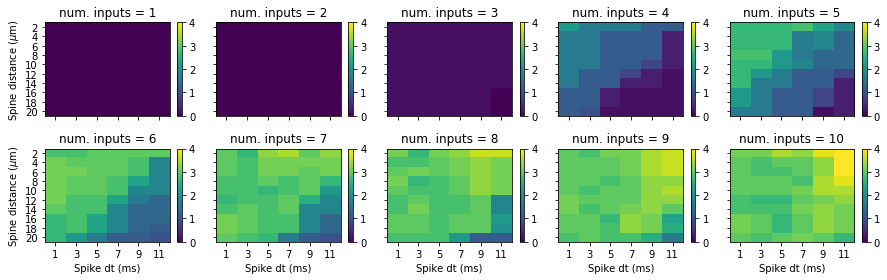

In [4]:
dt = np.unique(spike_dt)
dst = np.unique(spine_distance)
fig,ax = plt.subplots(rows, cols, figsize=(cols*2.5, rows*2), sharex=True, sharey=True)
n_presyn_spikes = len(n_spikes[0].keys())
writer = pd.ExcelWriter(f'synaptic_cooperativity_num_spikes_{cell_type}.xlsx')
if good_individuals is None:
    good_individuals = n_spikes.keys()
for i in range(rows):
    for j in range(cols):
        n_inputs = i * cols + j + 1
        tmp = [n_spikes[individual][n_inputs][np.newaxis,:,:] for individual in good_individuals]
        X = np.mean(np.vstack(tmp), axis=0)
        df = pd.DataFrame(X, index=dst, columns=dt)
        sheet_name = f'{n_inputs} inputs'
        df.to_excel(writer, sheet_name=sheet_name, header=True, startrow=1, startcol=1)
        sheet = writer.sheets[sheet_name]
        sheet.merge_cells(start_row=1, end_row=1, start_column=3, end_column=3+dt.size-1)
        sheet.merge_cells(start_row=3, end_row=3+dst.size-1, start_column=1, end_column=1)
        sheet.cell(1, 3, 'Presynaptic spikes dt (ms)')
        sheet.cell(3, 1, 'Spine distance (um)')
        sheet['1'][2].alignment = Alignment(vertical='center')
        sheet['3'][0].alignment = Alignment(vertical='center')
        im = ax[i,j].imshow(X, aspect='auto', cmap=colormap, vmin=0, vmax=vmax)
        plt.colorbar(im, ax=ax[i,j])
        ax[i,j].set_title(f'num. inputs = {n_inputs}')
        ax[i,j].set_xticks(np.arange(shape[1]))
        ax[i,j].set_xticklabels(np.unique(spike_dt))
        ax[i,j].set_yticks(np.arange(shape[0]))
        ax[i,j].set_yticklabels(np.unique(spine_distance))
        ax[-1,j].set_xlabel('Spike dt (ms)')
    ax[i,0].set_ylabel(r'Spine distance ($\mu$m)')
writer.save()
fig.tight_layout()
fig.savefig(f'synaptic_cooperativity_num_spikes_{cell_type}.pdf')